In [1]:
cd ~/Workspace/torchai/results/cartpole/

/home/pkubik/Workspace/torchai/results/cartpole


In [2]:
from helper import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

In [4]:
logs = read_all_logs(Path('raw'))

def compute_ext_stats(x):
    r = compute_stats(x)
    r.update({'num_episodes': len(x)})
    return r

stats = {k: compute_ext_stats(v) for k, v in logs.items()}

In [5]:
def df_by_dense_size(records):
    df = pd.DataFrame.from_records(records).T
    df['num_layers'] = df.index.map(lambda x: len(extract_layers_sizes(x)))
    df['dense_size'] = df.index.map(lambda x: extract_layers_sizes(x)[0])
    df['use_BN'] = df.index.map(lambda x: 'no-BN' not in x)
    df['activation_before_BN'] = df.index.map(lambda x: 'before-BN' in x)
    df['use_symmetry'] = df.index.map(lambda x: 'sym' in x)
    df['tanh_activation'] = df.index.map(lambda x: 'tanh' in x)
    return df

In [6]:
df = df_by_dense_size(stats)
df = df[df['num_layers'] == 2]
df = df[df['use_BN']]
df = df[df['tanh_activation'] == False]
df = df[df['num_episodes'] > 800]
df['solved_episode'] = df['solved_episode'].apply(lambda x: x if x > 0 else 2000)

In [7]:
df.head()

,duration_mean,duration_median,duration_std,largest_score,longest_duration,longest_episode,longest_fails_seq,longest_solved_seq,mean_fails_seq,num_episodes,solved_episode,num_layers,dense_size,use_BN,activation_before_BN,use_symmetry,tanh_activation
base_D-128-128_ELU_before-BN,65.364265,33.0,75.183478,144.140,1049.0,88.0,74.0,-1.0,8.567164,1013.0,2000.0,2,128,True,True,False,False
base_D-128-128_ELU_before-BN__2,61.154369,20.0,102.040409,152.110,1953.0,1023.0,157.0,-1.0,10.967742,1030.0,2000.0,2,128,True,True,False,False
base_D-128-128_ELU_before-BN__3,54.636723,25.0,63.705643,120.480,859.0,107.0,66.0,-1.0,8.115385,1013.0,2000.0,2,128,True,True,False,False
base_D-128-128_ELU_before-BN__4,53.004921,26.0,89.537674,115.616,2179.0,54.0,46.0,-1.0,6.292453,1016.0,2000.0,2,128,True,True,False,False
base_D-16-16_ELU_before-BN,63.988516,10.0,235.160983,473.380,3869.0,167.0,354.0,122.0,30.833333,1132.0,294.0,2,16,True,True,False,False


Mean duration by dense layer size
--------------------------------------

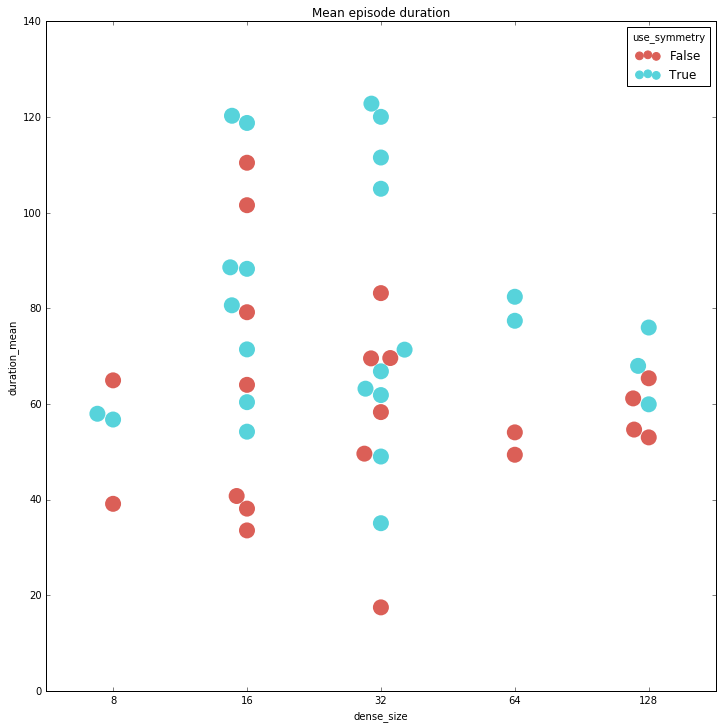

Fig. 1


In [8]:
plot = sns.swarmplot('dense_size', 'duration_mean', hue='use_symmetry', data=df, palette="hls", s=16)
plot.title.set_text('Mean episode duration')
plt.show()
print('Fig. 1')

Largest scores achieved by dense layer size
-------------------------------------------

The score is defined as the mean duration of the last 100 episodes. High score ensure good performance of the model by mitigating the influence of the failed episodes.

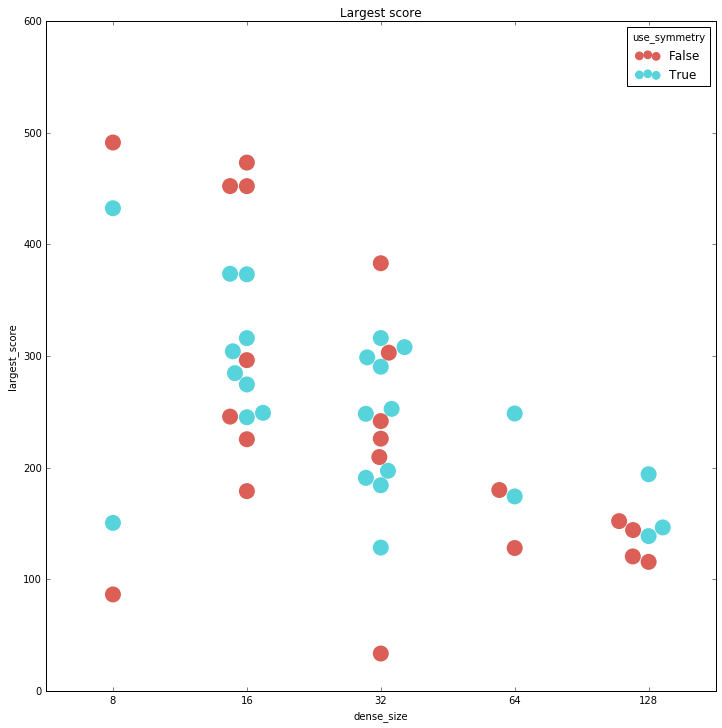

Fig. 2


In [9]:
plot = sns.swarmplot('dense_size', 'largest_score', hue='use_symmetry', data=df, palette="hls", s=16)
plot.title.set_text('Largest score')
plt.show()
print('Fig. 2')

Distribution of short episode lengths
------------------------------------------

It is interesting how utilizing problems symmetry results in slightly longer mean duration of each episode (fig. 1) but lower maximal score. I observed that the agent tends to cycle between sequences of episodes with   relatively long durations (> 100) and short sequences of episodes with very short duration (< 50, usually almost instantly fails). It might be the case that once the model achieve good performance it starts to overfit to some easier states of the environment (e.g. the pole standing still with minimal movement) because they slowly become majority of the replay buffer examples.

It seems like the sequences of failures consist of the episodes with slightly longer durations in case of the models which utilize symmetry.

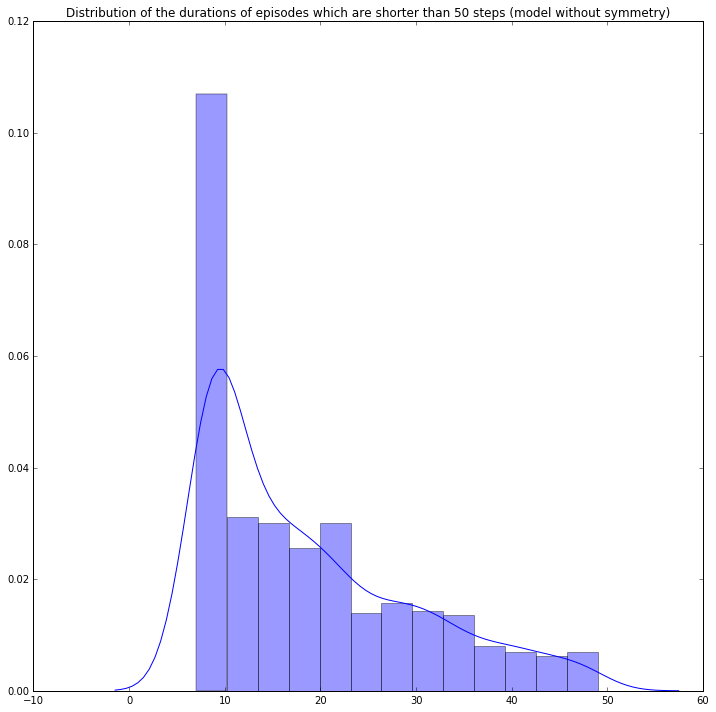

Fig. 3


In [10]:
log = logs['base_D-32-32_ELU_before-BN']
plot = sns.distplot(log[log['Duration'] < 50][['Duration']])
plot.title.set_text("Distribution of the durations of episodes which are shorter than 50 steps (model without symmetry)")
plt.show()
print('Fig. 3')

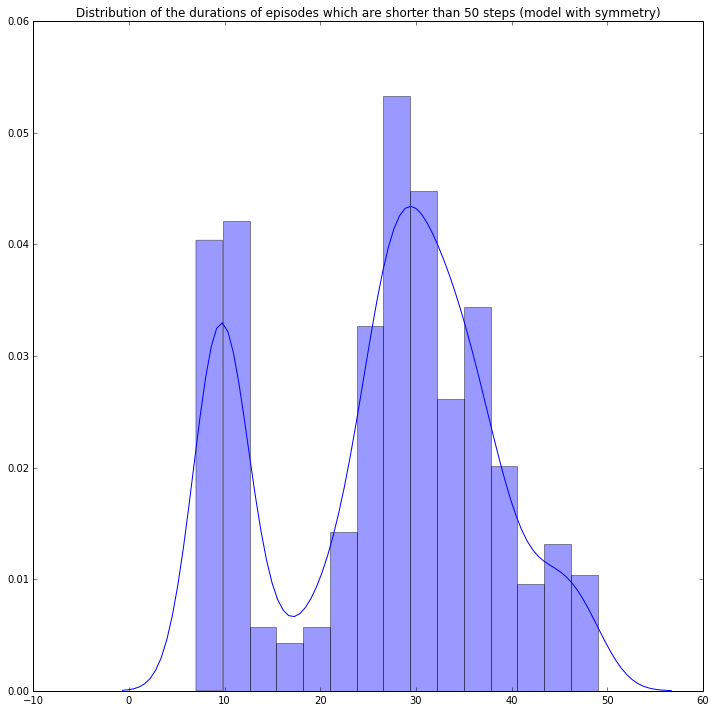

Fig. 4


In [11]:
log = logs['sym_D-32-32_ELU_before-BN']
plot = sns.distplot(log[log['Duration'] < 50][['Duration']])
plot.title.set_text("Distribution of the durations of episodes which are shorter than 50 steps (model with symmetry)")
plt.show()
print('Fig. 4')

We migh also consider the lengths of the longest sequence of short episodes (i.e. instant fails) for explaining fig. 1 and fig. 2 inconsistency, however it seems like there seems to be no pattern which would support the claim that those sequences are longer in case of the models with symmetry (fig. 5).

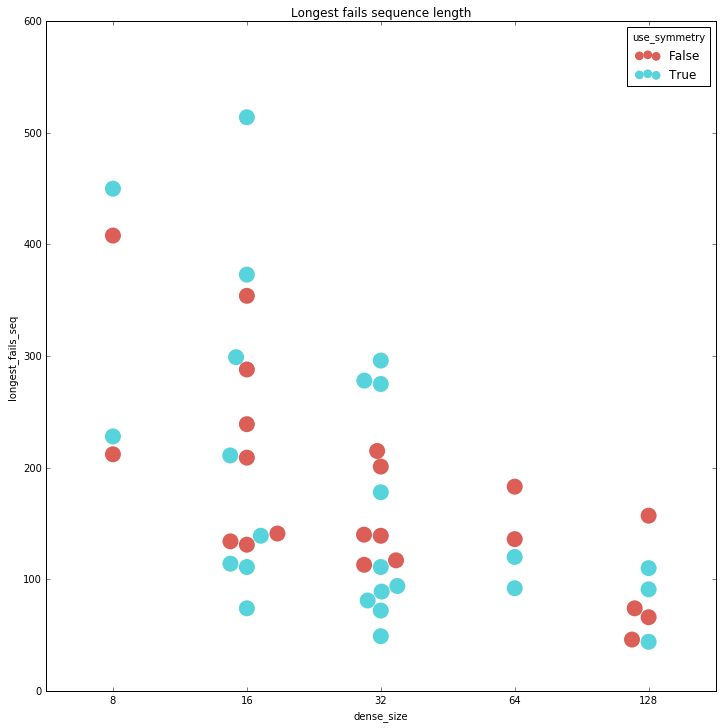

Fig. 5


In [17]:
plot = sns.swarmplot('dense_size', 'longest_fails_seq', hue='use_symmetry', data=df, palette="hls", s=16)
plot.title.set_text('Longest fails sequence length')
plt.show()
print('Fig. 5')

The time required to recover from the fails sequence gets lower with the size of the dense layers. On the other hand the same can be stated about the largest score (fig. 2). It seems that adding more variables decreases inertia of the training process.